In [143]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
import sys
MY_DRIVE_PATH = '/content/drive/MyDrive/Technion/Diffusion-AD-Project/'
sys.path.append(MY_DRIVE_PATH)
os.chdir(MY_DRIVE_PATH)

Mounted at /content/drive


In [144]:
!pip install blobfile
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [145]:
# Import libraries
from typing import Tuple
from random import sample
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.models import ModelLoader
from utils.noiser import Noiser, TimestepUniformNoiser
from utils.denoiser import Denoiser, ModelTimestepUniformDenoiser
from utils.error_map import ErrorMapGenerator, BatchFilteredSquaredError
from utils.anomaly_scorer import AnomalyScorer, MaxValueAnomalyScorer
from extern.guided_diffusion.guided_diffusion import gaussian_diffusion as gd

model_loaded = False

# <u>**Part 1: Import the Image**</u>

In [146]:
# IMAGE_PATH = "extern/mvtec/hazelnut/test/cut/013.png"
IMAGE_PATH = "extern/mvtec/hazelnut/test/good/000.png"

In [147]:
# Read the image and convert BGR to RGB
image = Image.open(IMAGE_PATH)

# Create a transformation composition to resize the image to a 64x64 image,
# and convert it to a torch Tensor.
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

img_t = transform(image)

Original (1024, 1024) image:


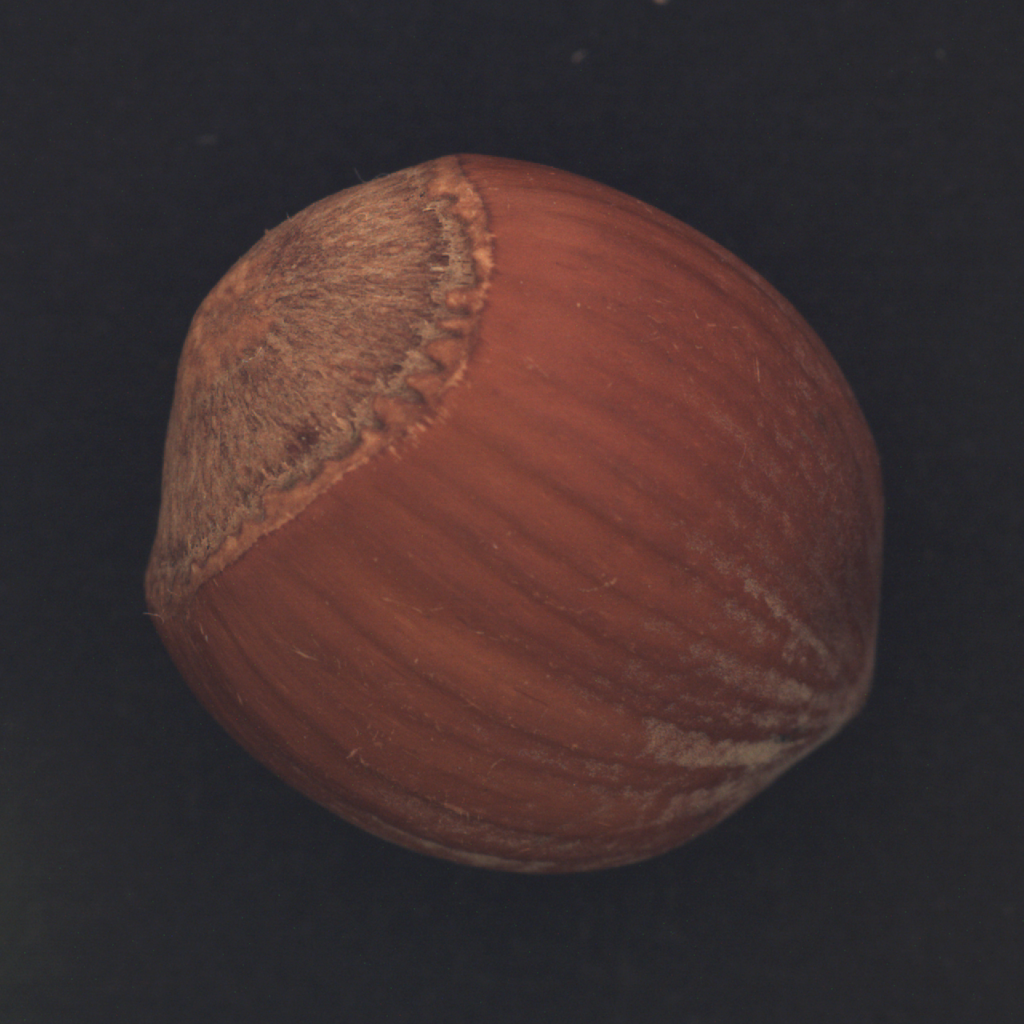

Transformed 3x256x256 image:


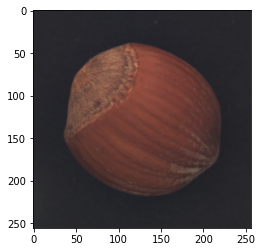

In [148]:
# Plot the chosen original image:
print(f'Original {image.size} image:')
display(image)

print(f'Transformed {"x".join([str(n) for n in img_t.shape])} image:')
plt.imshow(((img_t.permute(1, 2, 0) / 2) + 0.5).clip(0, 1), vmin=-1, vmax=1)
plt.show()

# **<u>Part 2: Noise the Image</u>**

In [149]:
torch.cuda.is_available()

True

In [150]:
# Load the model and create a corresponding diffusion object:
if not model_loaded:
  model_loader: ModelLoader = ModelLoader()
  model, diffusion = model_loader.get_model('256x256_uncond')
  model_loaded = True

In [178]:
# Create a noiser object and make some noise!!
noiser = TimestepUniformNoiser(diffusion)
NUM_TIMESTEPS = 180

In [179]:
noised_image = noiser.apply_noise(img_t.unsqueeze(0), NUM_TIMESTEPS).squeeze(0)

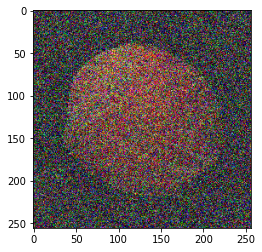

In [180]:
plt.imshow(((noised_image.permute(1, 2, 0) / 2) + 0.5).clip(0, 1))
plt.show()

# **<u>Part 3: Denoise the Image Using a Trained Model</u>**

In [181]:
# Create a denoiser and save the doge
denoiser = ModelTimestepUniformDenoiser(model, diffusion)
noised_image = noised_image.to('cuda')

In [182]:
reconstructed_image = denoiser.denoise(noised_image.unsqueeze(0), NUM_TIMESTEPS, show_progress=True)

  0%|          | 0/180 [00:00<?, ?it/s]

The noised image:


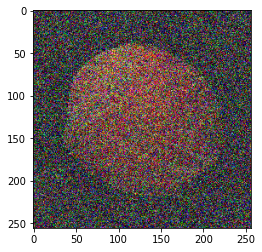

The reconstructed image:


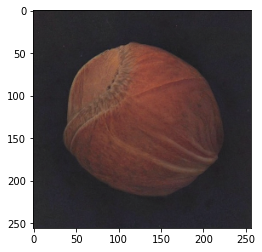

The original image:


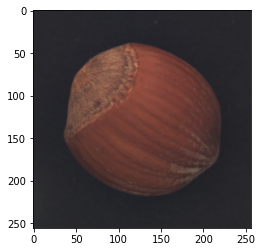

In [183]:
print('The noised image:')
noised_image_cpu = ((noised_image.squeeze(0).cpu() / 2) + 0.5).clip(0, 1)
plt.imshow(noised_image_cpu.permute(1, 2, 0))
plt.show()

print('The reconstructed image:')
reconstructed_image_cpu = ((reconstructed_image.squeeze(0).cpu() / 2) + 0.5).clip(0, 1)
plt.imshow(reconstructed_image_cpu.permute(1, 2, 0))
plt.show()

print('The original image:')
img_t_cpu = ((img_t / 2) + 0.5).clip(0, 1)
plt.imshow(img_t_cpu.permute(1, 2, 0))
plt.show()

In [184]:
error_map_gen = BatchFilteredSquaredError()
anomaly_scorer = MaxValueAnomalyScorer()

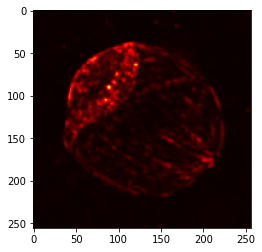

Anomaly Score: 0.05


In [185]:
anomaly_map = error_map_gen.generate(img_t_cpu, reconstructed_image_cpu.unsqueeze(0))
plt.imshow(anomaly_map, cmap='hot', interpolation='nearest', vmin=anomaly_map.min().item(), vmax=anomaly_map.max().item())
plt.show()

print(f'Anomaly Score: {anomaly_scorer(anomaly_map):.2f}')

# **<u>Part 4: Test using multiple noise iterations</u>**

In [186]:
def get_reconstructed_batch(model,
                            img: torch.TensorType,
                            noiser: Noiser,
                            denoiser: Denoiser,
                            num_timesteps: int,
                            batch_size: int,
                            interactive_print: bool=False) -> torch.TensorType:
  """
  Return:
  -------
  reconstructed_batch: Tensor
    A batch of batch_size reconstructed images from `img`.
  """
  reconstructed_batch = []

  # Noise and reconstruct `batch_size` times and aggregate into a batch
  for i in tqdm(range(batch_size)):
    curr_timesteps = torch.randint(low=int(num_timesteps * 0.9), high=int(num_timesteps * 1.1), size=[1]).item()
    noised_image = noiser.apply_noise(img.unsqueeze(0), curr_timesteps).squeeze(0).cuda()
    reconstructed_image = denoiser.denoise(noised_image.unsqueeze(0), curr_timesteps, show_progress=True)
    if interactive_print:
      print(f'Reconstructed image No. {i + 1}:')
      reconstructed_image_cpu = ((reconstructed_image.squeeze(0).cpu() / 2) + 0.5).clip(0, 1)
      plt.imshow(reconstructed_image_cpu.permute(1, 2, 0))
      plt.show()
    reconstructed_batch.append(((reconstructed_image.squeeze(0) / 2) + 0.5).clip(0, 1))

  # Aggregate results into a single tensor
  device = reconstructed_batch[0].device
  reconstructed_batch = torch.stack(reconstructed_batch).to(device)

  return reconstructed_batch

def evaluate_anomaly(img: torch.TensorType, 
                     reconstructed_batch: torch.TensorType,
                     error_map_gen: ErrorMapGenerator,
                     anomaly_scorer: AnomalyScorer) -> Tuple[torch.TensorType, float, torch.TensorType]:
  """
  Return:
  -------
  anomaly_map, anomaly_score
  """
  # Calculate an anomaly map using all of the results
  anomaly_map = error_map_gen.generate(img, reconstructed_batch)
  anomaly_score = anomaly_scorer.score(anomaly_map)

  return anomaly_map, anomaly_score


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Reconstructed image No. 1:


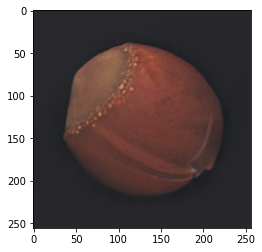

  6%|▋         | 1/16 [00:37<09:24, 37.61s/it]

  0%|          | 0/192 [00:00<?, ?it/s]

Reconstructed image No. 2:


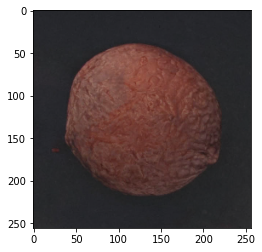

 12%|█▎        | 2/16 [01:20<09:26, 40.44s/it]

  0%|          | 0/175 [00:00<?, ?it/s]

Reconstructed image No. 3:


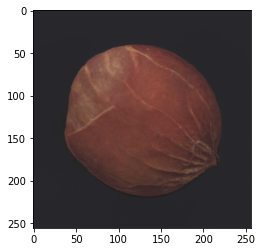

 19%|█▉        | 3/16 [01:58<08:34, 39.58s/it]

  0%|          | 0/173 [00:00<?, ?it/s]

Reconstructed image No. 4:


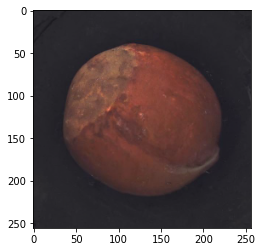

 25%|██▌       | 4/16 [02:36<07:49, 39.09s/it]

  0%|          | 0/184 [00:00<?, ?it/s]

Reconstructed image No. 5:


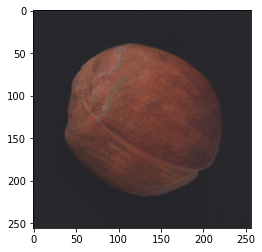

 31%|███▏      | 5/16 [03:17<07:16, 39.68s/it]

  0%|          | 0/168 [00:00<?, ?it/s]

Reconstructed image No. 6:


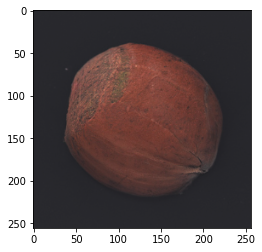

 38%|███▊      | 6/16 [03:54<06:27, 38.80s/it]

  0%|          | 0/171 [00:00<?, ?it/s]

Reconstructed image No. 7:


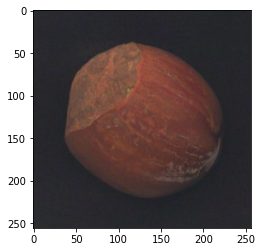

 44%|████▍     | 7/16 [04:32<05:45, 38.42s/it]

  0%|          | 0/167 [00:00<?, ?it/s]

Reconstructed image No. 8:


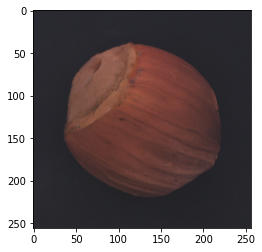

 50%|█████     | 8/16 [05:09<05:04, 38.04s/it]

  0%|          | 0/178 [00:00<?, ?it/s]

Reconstructed image No. 9:


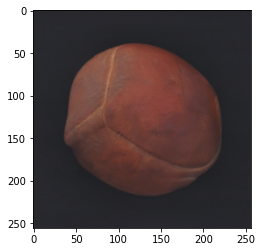

 56%|█████▋    | 9/16 [05:48<04:28, 38.40s/it]

  0%|          | 0/169 [00:00<?, ?it/s]

Reconstructed image No. 10:


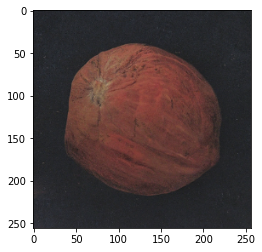

 62%|██████▎   | 10/16 [06:26<03:48, 38.08s/it]

  0%|          | 0/165 [00:00<?, ?it/s]

Reconstructed image No. 11:


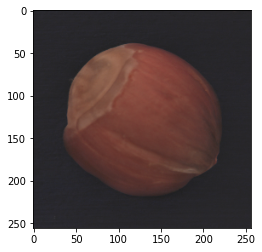

 69%|██████▉   | 11/16 [07:02<03:08, 37.62s/it]

  0%|          | 0/179 [00:00<?, ?it/s]

Reconstructed image No. 12:


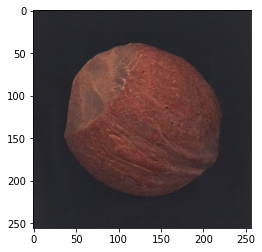

 75%|███████▌  | 12/16 [07:42<02:32, 38.23s/it]

  0%|          | 0/171 [00:00<?, ?it/s]

Reconstructed image No. 13:


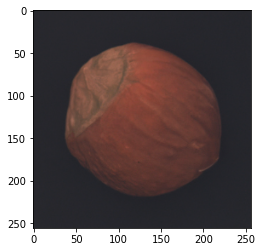

 81%|████████▏ | 13/16 [08:20<01:54, 38.12s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

Reconstructed image No. 14:


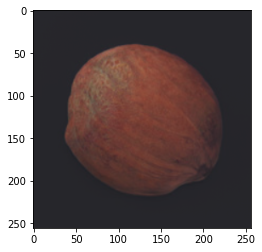

 88%|████████▊ | 14/16 [09:00<01:17, 38.70s/it]

  0%|          | 0/195 [00:00<?, ?it/s]

Reconstructed image No. 15:


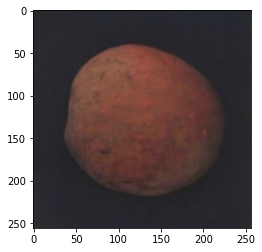

 94%|█████████▍| 15/16 [09:43<00:40, 40.00s/it]

  0%|          | 0/184 [00:00<?, ?it/s]

Reconstructed image No. 16:


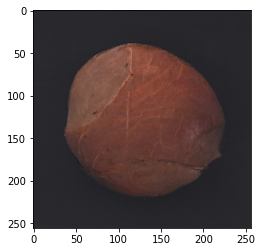

100%|██████████| 16/16 [10:24<00:00, 39.00s/it]


In [187]:
reconstructed_batch = get_reconstructed_batch(model,
                                              img_t,
                                              noiser,
                                              denoiser,
                                              NUM_TIMESTEPS,
                                              batch_size=16,
                                              interactive_print=True)

In [191]:
# Create an anomaly map averaging over all the reconstructed images
anomaly_map, anomaly_score = evaluate_anomaly(((img_t / 2) + 0.5).cuda(),
                                              reconstructed_batch,
                                              error_map_gen,
                                              anomaly_scorer)

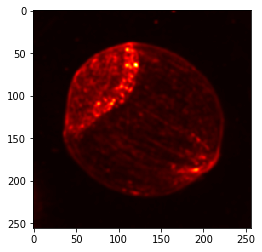

Anomaly Score: 0.03


In [192]:
anomaly_map = error_map_gen.generate(((img_t / 2) + 0.5).cuda(), reconstructed_batch).cpu()
plt.imshow(anomaly_map, cmap='hot', interpolation='nearest', vmin=anomaly_map.min().item(), vmax=anomaly_map.max().item())
plt.show()

print(f'Anomaly Score: {anomaly_scorer(anomaly_map):.2f}')

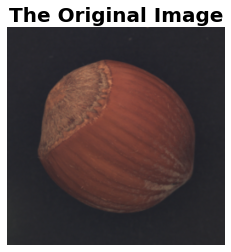

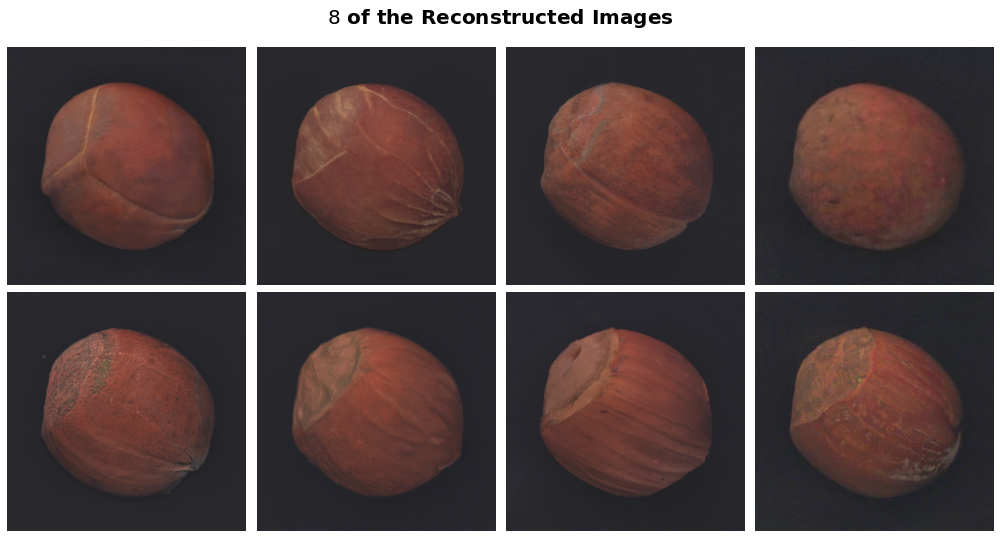

In [193]:
NUM_TO_PRINT = 8
columns = 4
rows = np.ceil(NUM_TO_PRINT / columns)
indices_to_plot = sample(range(len(reconstructed_batch)), NUM_TO_PRINT)

plt.imshow(img_t_cpu.permute(1, 2, 0))
plt.title('The Original Image', fontsize=20, fontweight='bold')
plt.axis('off')
plt.show()

fig = plt.figure(figsize=(rows * 7, columns * 2))
fig.suptitle(f'${NUM_TO_PRINT}$ of the Reconstructed Images', fontsize=20, fontweight='bold')

for serial_number, i in enumerate(indices_to_plot, start=1):
  fig.add_subplot(rows, columns, serial_number)
  plt.imshow(reconstructed_batch[i].permute(1, 2, 0).cpu())
  plt.axis('off')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()